# Risk-Aware Machine Learning Classifier for Skin Lesion Diagnosis

### Aryan Mobiny, Aditi Singh, Hien Van Nguyen, Journal of Clinical Medicine, 2019

<img src="imgs/fig1.png" width="5000" height="100" >

# 0. Import the required packages

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Model
from models import backbone
from config import options
from utils.py_utils import one_hot, softmax, load_data
from utils.eval_utils import uncertainty_fraction_removal, normalized_uncertainty_toleration_removal
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# 1. Load the data

<img src="imgs/fig2.png" width="500" height="100" >

## skin lesion categories

- Melanoma (MEL) 
- Melanocytic Nevi (NV) 
- Basal Cell Carcinoma (BCC) 
- Actinic Keratoses and Intraepithelial Carcinoma (AKIEC) 
- Benign Keratosis (BKL) 
- Dermatofibroma (DF) 
- Vascular (VASC) 

In [2]:
BASE_DIR = os.getcwd()
data_dir = os.path.join(BASE_DIR, 'preprocessed_data.h5')
x_train, y_train, x_valid, y_valid = load_data(data_dir)

In [3]:
print('Training images: {}'.format(x_train.shape))
print('Training labels: {}\n'.format(y_train.shape))
print('Validation images: {}'.format(x_valid.shape))
print('Validation labels: {}'.format(y_valid.shape))

Training images: (8010, 224, 224, 3)
Training labels: (8010, 7)

Validation images: (2005, 224, 224, 3)
Validation labels: (2005, 7)


# 2. Create the Model

### DenseNet-169



<img src="imgs/fig3.png" width="800" height="100" >




### In Keras:

<img src="imgs/fig4.PNG" width="800" height="100" >



## 2.1. Model parameters

In [4]:
# These can also be set up and imported from config.py
backbone_name = 'densenet169'
num_cls = 7
dropout_rate = 0.5
num_dense_layers = 1
num_dense_units = 128
pooling = 'avg'
dense_layer_regularizer = 'L2'
model_name = 'lesion_densenet169'
lr = 1e-4

In [5]:
save_dir = os.path.join(base_dir, 'default_save_dir')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [ ]:
from models import backbone
from utils.eval_utils import compute_class_weights
from utils.callback_utils import config_cls_callbacks

callbacks = config_cls_callbacks()

model = backbone(backbone_name).classification_model(input_shape=x_train.shape[1:],
                                                     num_classes=options.num_classes,
                                                     num_dense_layers=options.num_dense_layers,
                                                     num_dense_units=options.num_dense_units,
                                                     pooling=options.pooling,
                                                     dropout_rate=options.dropout_rate,
                                                     kernel_regularizer='L2',
                                                     save_to=save_dir,
                                                     print_model_summary=False,
                                                     plot_model_summary=False,
                                                     lr=options.lr)

class_weights = compute_class_weights(y_train, wt_type='balanced')

batch_size = 2

model.fit(x=x_train,
          y=y_train,
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(x_valid, y_valid),
          class_weight=class_weights,
          shuffle=True,
          callbacks=callbacks)

## 2.2. Start the Evaluation

### 2.2.1. Normal Evaluation

In [ ]:
# Don't run this; run the following cell to load the results
model = backbone(backbone_name).classification_model(load_weights_from=model_name,
                                                     num_classes=num_cls,
                                                     num_dense_layers=num_dense_layers,
                                                     num_dense_units=num_dense_units,
                                                     dropout_rate=0.,
                                                     pooling=pooling,
                                                     kernel_regularizer=dense_layer_regularizer)

y_pred = model.predict(x_valid)
y_prob = softmax(y_pred)

In [6]:
# Load from the saved file
file_name = os.path.join(base_dir, 'predictions.h5')
h5f = h5py.File(file_name, 'r')
y_prob = h5f['y_prob'][:]
h5f.close()

### 2.2.2. MC-Evaluation

In [7]:
monte_carlo_simulations = 10

In [ ]:
# Don't run this; run the following cell to load the results
model = backbone(backbone_name).classification_model(load_weights_from=model_name,
                                                     num_classes=num_cls,
                                                     num_dense_layers=num_dense_layers,
                                                     num_dense_units=num_dense_units,
                                                     pooling=pooling,
                                                     dropout_rate=dropout_rate,
                                                     kernel_regularizer=dense_layer_regularizer)

y_prob_mc = np.zeros((monte_carlo_simulations, y_valid.shape[0], num_cls))

for mc_iter in range(monte_carlo_simulations):
    print('MC iteration #{}'.format(mc_iter))
    y_prob_mc[mc_iter] = model.predict(x_valid)
    

In [8]:
# Load from the saved array (instead of running the above loop)
file_name = os.path.join(base_dir, 'MC_predictions.h5')
h5f = h5py.File(file_name, 'r')
y_prob_mc = h5f['y_prob'][:]
h5f.close()

#### - Compute the predictions

In [9]:
from IPython.display import Math
Math(r'\mu_{pred} \approx \frac{1}{T}\sum_{t=1}^T p(y^*|\mathbf{x}^*, \hat{\mathbf{w}}_t)')

<IPython.core.display.Math object>

In [10]:
mean_prob = y_prob_mc.mean(axis=0)        # prediction probabilities of shape [2005, 7]
y_pred = mean_prob.argmax(axis=1)         # predicted class labels of shape [2005,]

#### - Compute the uncertainty estimates (using predictive entropy)

In [11]:
Math(r'H(\mathbf{y^*\mathbf{| \mathbf{x}^*, \mathcal{D}}}) = - \sum_c p(y^*=c|\mathbf{x}^*, \mathcal{D})\,\text{log} \, p(y^*=c|\mathbf{x}^*, \mathcal{D})')

<IPython.core.display.Math object>

In [12]:
def predictive_entropy(prob):
    """
    Entropy of the probabilities (to measure the epistemic uncertainty)
    :param prob: probabilities of shape [batch_size, C]
    :return: Entropy of shape [batch_size]
    """
    eps = 1e-5
    return -1 * np.sum(np.log(prob+eps) * prob, axis=1)


H = predictive_entropy(mean_prob)

# Let's normalize the uncertainty values (in range [0, 1])
H_norm = (H - H.min()) / (H.max() - H.min())

# 3. Analyze the Results

## 3.1. Compare the prediction performance

In [13]:
acc_reg = 1 - np.count_nonzero(np.not_equal(y_prob.argmax(axis=1), y_valid.argmax(axis=1))) / mean_prob.shape[0]
acc_mc = 1 - np.count_nonzero(np.not_equal(mean_prob.argmax(axis=1), y_valid.argmax(axis=1))) / mean_prob.shape[0]
print('Accuracy of Standart DenseNet-169 = {:.02%}'.format(acc_reg))
print('Accuracy of Bayesian DenseNet-169 = {:.02%}'.format(acc_mc))

Accuracy of Standart DenseNet-169 = 88.23%
Accuracy of Bayesian DenseNet-169 = 88.23%


## 3.2. Uncertainty of correct/incorrect predictions

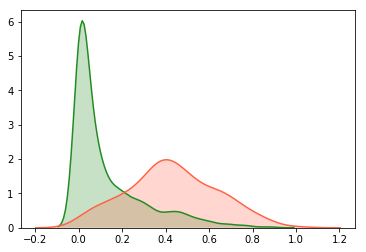

In [14]:
sns.kdeplot(H_norm[y_valid.argmax(axis=1) == y_pred], shade=True, color='forestgreen')
sns.kdeplot(H_norm[y_valid.argmax(axis=1) != y_pred], shade=True, color='tomato')

### This shows that the model is generally less confident when predictions are incorrect. 

### Now let's look at some of the predictions and the estimated uncertainty values:
(figure from the original paper)

<img src="imgs/fig5.PNG" width="800" height="100" >


## 3.3. Uncertainty-Aware Skin Lesion Referral


### 3.3.1. Accuracy as a function of tolerated uncertainty

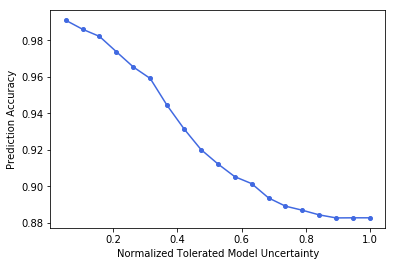

In [15]:
num_intervals = 20
normalized_uncertainty_toleration_removal(y_valid.argmax(axis=1), y_pred, H_norm, num_intervals)


### 3.3.2. Accuracy as a function of fraction of referrals

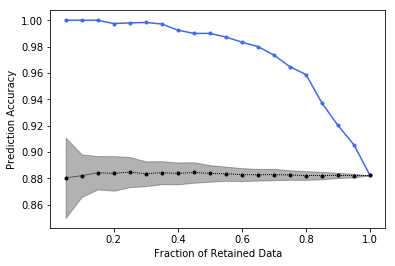

In [16]:
reps_for_random = 40
num_fractions = 20
uncertainty_fraction_removal(y_valid.argmax(axis=1), y_pred, H_norm, num_fractions, reps_for_random)